In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ======================================================================
# Created By  : Mike G
# Created Date: Sunday Jan 30 10:00:00 UTC 2022
# ======================================================================
########################################################################
# Import default python-library
########################################################################
import os
import glob
import numpy as np
import time, datetime
import itertools
from pathlib import Path
########################################################################
# Import libraries
#It used only for read_csv in this tutorial
import pandas as pd # for data analysis

########################################################################
# Import additional python-library
########################################################################
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_recall_curve

from sklearn.model_selection import validation_curve, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif

########################################################################
# original lib
########################################################################
from include import common, models
import librosa
########################################################################

########################################################################
# for plotting
########################################################################
import seaborn as sns # for Data visualization
import matplotlib.pyplot as plt # for Data visualization
import warnings
warnings.filterwarnings('ignore')

########################################################################
#show pandas version
########################################################################
pd.__version__
########################################################################

'1.3.5'

In [2]:
#################################################################################
# l'extension du fichier de données a importer.
#################################################################################
EXT = '.csv'
#################################################################################
# Le répertoire racine des données audio dev_data et eval_data
#################################################################################
DATASET_ROOT = './../data'
#################################################################################
# Les dossiers dans lesquels se trouvent les audios.
#################################################################################
AUDIO_DEV_SUBFOLDER = 'dev_data'
MODEL_SUBFOLDER = 'models'
#################################################################################
DATASET_AUDIO_DEV_PATH = Path(DATASET_ROOT , AUDIO_DEV_SUBFOLDER)
MODELS_PATH    = Path(DATASET_ROOT , MODEL_SUBFOLDER)
#################################################################################
# Paramètres des fonctions audio Librosa
#################################################################################
n_mfcc=64
n_mels=128
n_fft=8192
hop_length=4096
#################################################################################
# Paramètres des fonctions audio Librosa
#################################################################################
sec_cut = 10.0
offset_cut = 0.0
split_data = 0.2
#################################################################################


In [3]:
#* normal/anomaly = 0/1
# Define a preprocessing function
def preprocessing(dataframe,col):
    df = dataframe.copy()

    # List of column
    col_name = df.columns.values.tolist()
    
    # Deleting some columns from the data
    df = df[df.columns[~df.columns.isin([col_name[0], col_name[1], col_name[2], col_name[3]])]]
    
    # Convert categorical values to integer
    new_df_b = df.copy()
    #new_df_b.drop(col_name[0], axis=1, inplace=True)
    new_df_b[col] = np.where(new_df_b[col]=='normal', 0, 1)
     
    X = new_df_b.drop(col, axis=1)
    y = new_df_b[col]
        
#    return X, y
    return train_test_split(X, y, test_size = .2, random_state=1)

def rmse_cv(model, X, y):
    model_ = model.fit(X, y)
    score_model = cross_val_score(model_, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    if score_model < 0 :
        return np.sqrt(-score_model)
    else:
        return np.sqrt(score_model)

def evaluation(model, X, y):    
    start_time = time.time()
    # fitting the model for grid search
    model.fit(X_train, y_train)
    ################################
    # Finding Test-Model Accuracy
    ################################
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)    
    # evaluate predictions
    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)*100
    print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
    print(f'score : {model.score(X_test, y_test):.2%}')

    # Lets's see what the error in the best sample is for the found values of the algorithm parameters :
    err_train = np.mean(y_train != y_train_pred)
    err_test = np.mean(y_test != y_test_pred)
    print(f'\nerr_train : {err_train:.3f}, err_test : {err_test:.3f}') 
    mae = mean_absolute_error(y_true = y_test, y_pred = y_test_pred)
    mse_train = mean_squared_error(y_true = y_train, y_pred = y_train_pred)
    mse_test = mean_squared_error(y_true = y_test, y_pred = y_test_pred)
    rmse = rmse_cv(model, X, y)

    end_time = time.time() - start_time
    
    # Create a confusion matrix
    cnf_matrix = confusion_matrix(y_true = y_test, y_pred = y_test_pred)
    # Create a classification report
    class_report = classification_report(y_true = y_test, y_pred = y_test_pred)

    print(f'Durée : {datetime.timedelta(seconds =end_time)}s')
#    print(f'Durée : {end_time:.2f} seconds') 
    print(f'MAE : {mae:.3f}') 
    print(f'RMSE : {rmse:.3f}') 
    print(f'mse train : {mse_train:.3f}') 
    print(f'mse test : {mse_test:.3f}') 
    print(f'err_train : {err_train:.3f}, err_test : {err_test:.3f}') 

    # Create heatmap from the confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    class_names=['normal', 'anomaly']
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(class_names)) #[0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')

    # construire la courbe ROC
    fpr, tpr, thr = roc_curve(y_true = y_test, y_score = y_test_pred)

    # calculer l'aire sous la courbe ROC
    #auc = auc(fpr, tpr)

    # créer une figure
    plt.figure(figsize=(4, 4))

    # afficher la courbe ROC
    plt.plot(fpr, tpr, '-', lw=2, label='AUC=%.2f' % auc(fpr, tpr))

    # donner un titre aux axes et au graphique
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve', fontsize=16)

    # afficher la légende
    plt.legend(loc="lower right", fontsize=14)

    # afficher l'image
    plt.show();  
    
#####################################################################################################

#df_fan = df_mel_test[df_mel_test.machine_type == 'fan'].reset_index(drop=True)
#df_ToyConveyor = df_mel_test[df_mel_test.machine_type == 'ToyConveyor'].reset_index(drop=True)
#df_ToyCar = df_mel_test[df_mel_test.machine_type == 'ToyCar'].reset_index(drop=True)
#df_pump = df_mel_test[df_mel_test.machine_type == 'pump'].reset_index(drop=True)
#df_valve = df_mel_test[df_mel_test.machine_type == 'valve'].reset_index(drop=True)
#df_slider = df_mel_test[df_mel_test.machine_type == 'slider'].reset_index(drop=True)
#print(df_ToyConveyor.shape, df_ToyCar.shape, df_pump.shape, df_fan.shape, df_valve.shape, df_slider.shape)


#* normal/anomaly = 0/1
#feats = df_fan.drop(columns = ['pathname', 'machine_type', 'machine_kind', 'data_split', 'condition'])
#target = df_fan.condition.apply(lambda x: 0 if x == 'normal' else 1)
#X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = .2, random_state=1)
#df_fan = df_mel_test[df_mel_test.machine_type == 'fan'].reset_index(drop=True)
#trainset, testset = train_test_split(df_fan, test_size=0.2, random_state=1)
#X_train, y_train = preprocessing(trainset,'condition')
#X_test, y_test = preprocessing(testset,'condition')
## Create histograms for feature columns
#y_train.hist(bins=30, figsize=(12, 8), color='blue', alpha=0.4, label='Train')
#y_test.hist(bins=30, figsize=(12, 8), color='red', alpha=0.4, label='Test')
#plt.suptitle("Histogram for each categorical input variable", fontsize=10)
#plt.legend()
#plt.show();
#DecisionTree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))#
#RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0)#)
#AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
#SVM = make_pipeline(preprocessor, SVC(random_state=0))
#KNN = make_pipeline(preprocessor, KNeighborsClassifier(random_state=0))

#dict_of_models = {'DecisionTree': DecisionTree,
#                  'RandomForest': RandomForest,
#                  'AdaBoost' : AdaBoost,
#                  'SVM': SVM,
#                  'KNN': KNN
#                 }

#for name, model in dict_of_models.items():
#    print(name, ':')
#    evaluation(model)

In [4]:
#* normal/anomaly = 0/1
df = common.load_metadata(DATASET_AUDIO_DEV_PATH, EXT)

Chargement du fichier <dev_data.csv> des métadonnées audio...
Terminé.


In [5]:
data=df.copy()

In [6]:
# First rows of `df`
display(data.head(3).style.set_properties(**{'background-color': 'lightyellow',
                           'color': 'darkblack',
                           'border-color': 'darkblack'}))



,pathname,filename,machine_id,sample_id,audio_format,machine_type,machine_kind,data_split,condition,durations,samplingrate
0,..\data\dev_data\ToyCar\test\anomaly_id_01_00000092.wav,anomaly_id_01_00000092.wav,id_01,00000092,.wav,ToyCar,real_machine,test,anomaly,11.000000,16000
1,..\data\dev_data\valve\train\normal_id_02_00000037.wav,normal_id_02_00000037.wav,id_02,00000037,.wav,valve,real_machine,train,normal,10.000000,16000
2,..\data\dev_data\slider\train\normal_id_02_00000429.wav,normal_id_02_00000429.wav,id_02,00000429,.wav,slider,real_machine,train,normal,10.000000,16000


In [7]:
train_data = data[data.data_split == 'train'].reset_index(drop=True)
test_data = data[data.data_split == 'test'].reset_index(drop=True)
print(train_data.shape, test_data.shape)

(20119, 11) (10868, 11)


In [8]:
ext = '.ftr'
df_mel_test = common.create_mel_data(DATASET_AUDIO_DEV_PATH, test_data, 'mel_data_test', ext, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, duration=sec_cut)
df_mel_test.head()
del train_data, test_data

Chargement du fichier <mel_data_test.ftr> des métadonnées audio...
Terminé.


# Best Parameters
## ToyConveyor
* Best parameters =  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
* CV error = 2.7787239450940575
* Accuracy for our training dataset with tuning is : 97.22%
* Accuracy for our testing dataset with tuning is : 97.58%

* err_train : 0.000, err_test : 0.024
* score : 97.58%
* Durée : 4:17:17.174229s

## ToyCar
* Best parameters =  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
* CV error = 1.169584585103081
* Accuracy for our training dataset with tuning is : 98.83%
* Accuracy for our testing dataset with tuning is : 98.98%

* err_train : 0.000, err_test : 0.010
* score : 98.98%
* Durée : 0:05:44.068510s

## fan
* Best parameters =  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
* CV error : 9.000
* Accuracy for our training dataset with tuning is : 91.00%
* Accuracy for our testing dataset with tuning is : 87.47%

* err_train : 0.001, err_test : 0.125
* score : 87.47%
* Durée : 0:03:21.376874s

## pump
* Best parameters =  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
* CV error = 10.81841432225066
* Accuracy for our training dataset with tuning is : 89.18%
* Accuracy for our testing dataset with tuning is : 86.63%

* err_train : 0.000, err_test : 0.134
* score : 86.63%
* Durée : 0:01:01.035577s

## valve
* Best parameters =  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
* CV error = 24.06036217303823
* Accuracy for our training dataset with tuning is : 75.94%
* Accuracy for our testing dataset with tuning is : 80.11%

* err_train : 0.000, err_test : 0.199
* score : 80.11%
* Durée : 0:01:05.257901s

## slider
* Best parameters =  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
* CV error = 7.460791635548929
* Accuracy for our training dataset with tuning is : 92.54%
* Accuracy for our testing dataset with tuning is : 95.74%

* err_train : 0.000, err_test : 0.043
* score : 95.74%
* Durée : 0:01:55.049420s

# slider

In [70]:
df_machine = df_mel_test[df_mel_test.machine_type == 'fan'].reset_index(drop=True)
X = df_machine.drop(columns = ['pathname', 'machine_type', 'machine_kind', 'data_split', 'condition']).copy()
y = df_machine.condition.apply(lambda x: 0 if x == 'normal' else 1).copy()
X_train, X_test, y_train, y_test = preprocessing(df_machine,'condition')


In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X.shape, y.shape

((1500, 5120), (375, 5120), (1500,), (375,), (1875, 5120), (1875,))

In [72]:
#Standardisation des données
# sc = StandardScaler()
pipeline = Pipeline([('scaler', StandardScaler()), ('minmax', MinMaxScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

## Modélisation

### RF

Accuracy for our testing dataset with tuning is : 80.34%
score : 80.34%

err_train : 0.000, err_test : 0.197
Durée : 0:01:16.014205s
MAE : 0.197
RMSE : 0.450
mse train : 0.000
mse test : 0.197
err_train : 0.000, err_test : 0.197


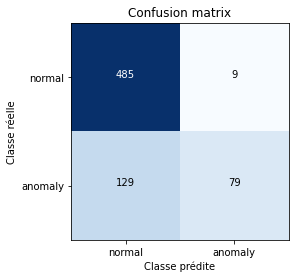

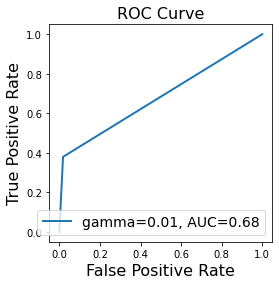

In [12]:
model_0 = RandomForestClassifier(random_state=0)
evaluation(model_0, X, y)

Accuracy for our testing dataset with tuning is : 70.37%
score : 70.37%

err_train : 0.321, err_test : 0.296
Durée : 0:00:14.635456s
MAE : 0.296
RMSE : 0.562
mse train : 0.321
mse test : 0.296
err_train : 0.321, err_test : 0.296


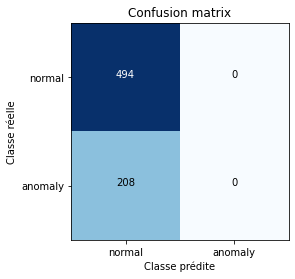

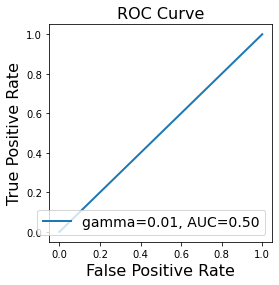

In [13]:
model_1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
evaluation(model_1, X, y)

Accuracy for our testing dataset with tuning is : 79.06%
score : 79.06%

err_train : 0.009, err_test : 0.209
Durée : 0:00:57.322685s
MAE : 0.209
RMSE : 0.471
mse train : 0.009
mse test : 0.209
err_train : 0.009, err_test : 0.209


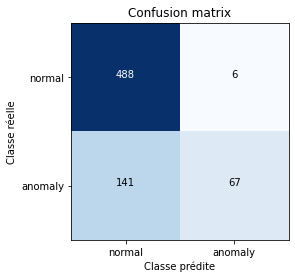

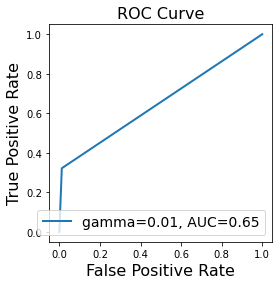

In [14]:
model_2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
evaluation(model_2, X, y)

### DecisionTree

Accuracy for our testing dataset with tuning is : 64.53%
score : 64.53%

err_train : 0.283, err_test : 0.355
Durée : 0:00:51.949076s
MAE : 0.355
RMSE : 0.560
mse train : 0.283
mse test : 0.355
err_train : 0.283, err_test : 0.355


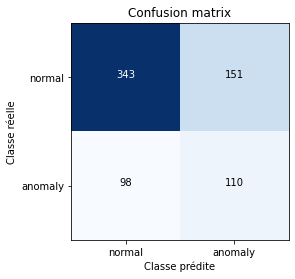

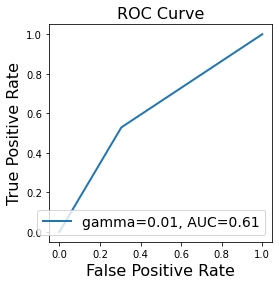

In [15]:
model_3 = DecisionTreeClassifier(criterion='entropy',max_depth=4)
evaluation(model_3, X, y)

### KNN

Accuracy for our testing dataset with tuning is : 85.75%
score : 85.75%

err_train : 0.076, err_test : 0.142
Durée : 0:00:04.922829s
MAE : 0.142
RMSE : 0.419
mse train : 0.076
mse test : 0.142
err_train : 0.076, err_test : 0.142


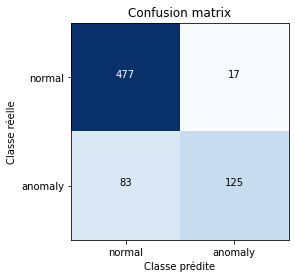

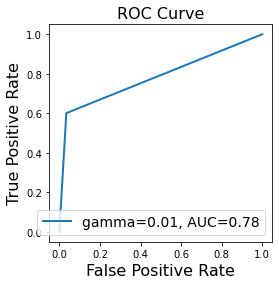

In [16]:
model_4 = KNeighborsClassifier()
evaluation(model_4, X, y)

Accuracy for our testing dataset with tuning is : 82.62%
score : 82.62%

err_train : 0.113, err_test : 0.174
Durée : 0:00:04.664520s
MAE : 0.174
RMSE : 0.450
mse train : 0.113
mse test : 0.174
err_train : 0.113, err_test : 0.174


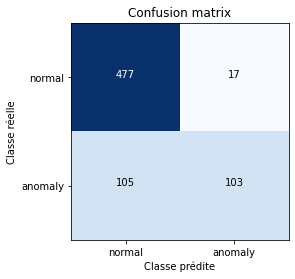

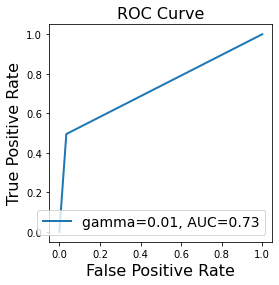

In [17]:
model_5 = KNeighborsClassifier(n_neighbors=7, metric='minkowski')
evaluation(model_5, X, y)

Accuracy for our testing dataset with tuning is : 85.19%
score : 85.19%

err_train : 0.052, err_test : 0.148
Durée : 0:08:23.527376s
MAE : 0.148
RMSE : 0.405
mse train : 0.052
mse test : 0.148
err_train : 0.052, err_test : 0.148


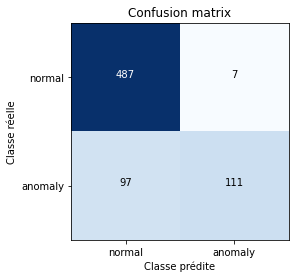

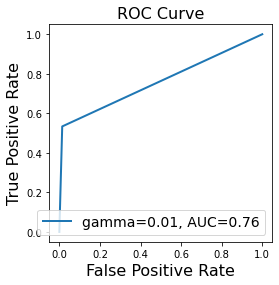

In [18]:
model_6 = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
evaluation(model_6, X, y)

In [19]:
#score_rmse = []
#k_ = np.arange(1,50)

#plt.figure(figsize=(10, 7))

#for k in k_:
#    knn = KNeighborsClassifier(k)
#    rmse = rmse_cv(knn, X, y)
#    score = knn.fit(X, y).score(X, y)
#    pred_target = knn.fit(X, y).predict(X)
#    mse = mean_squared_error(y, pred_target) 
#    score_rmse.append(rmse)
#    print("k:{0}, R2:{1:.4f}, MSE:{2:.4f}, RMSE:{3:.4f}, RMSE_1:{4:.4f}".format(k, score, mse, rmse, np.sqrt(mse)))
#    print("Alpha:{0:.2f}, RMSE:{1:.2f}".format(a, rmse))

#plt.plot(k_, score_rmse, color='blue', linestyle='dashed', lw=2, label='model_Ridge')
#plt.xlabel('k')
#plt.ylabel('Root Mean squared error')
#plt.legend();

In [20]:
parameters_knn = {
    'n_neighbors':np.arange(2,50), 
    'weights': ['uniform', 'distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, parameters_knn, cv=5)

grid.fit(X_train, y_train)
#
best_cv_err = 1 - grid.best_score_
#
best_parameters_knn = grid.best_params_
#
best_model_knn = grid.best_estimator_
#
best_n_neighbors = grid.best_estimator_.n_neighbors
#
best_weights = grid.best_estimator_.weights
#
best_algorithm = grid.best_estimator_.algorithm
#
best_metric = grid.best_estimator_.metric
#
best_score_knn = best_model_knn.score(X_test, y_test)
#
y_test_predict = best_model_knn.predict(X_test)
#

print(f'Error rate : {best_cv_err:.2%}') 
print(f'Score : {best_score_knn:.2%}') 
print(f'Best parameters : {best_parameters_knn}')

print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_test_predict)}')

Error rate : 9.80%
Score : 91.88%
Best parameters : {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Confusion Matrix: 
[[465  29]
 [ 28 180]]


Accuracy for our testing dataset with tuning is : 91.88%
score : 91.88%

err_train : 0.000, err_test : 0.081
Durée : 0:02:12.887103s
MAE : 0.081
RMSE : 0.316
mse train : 0.000
mse test : 0.081
err_train : 0.000, err_test : 0.081


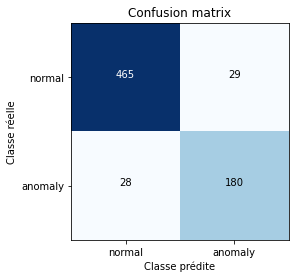

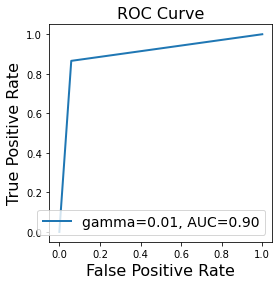

In [21]:
#Let us check what errors in the training and test samples are equal for this parameters values
model_7 = KNeighborsClassifier(n_neighbors = best_n_neighbors, weights = best_weights, algorithm=best_algorithm, metric=best_metric)

evaluation(model_7, X, y)

Best_k : 1
Best_score rate : 84.57%


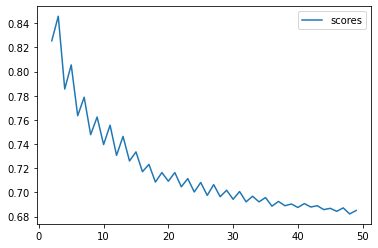

In [22]:
knn = KNeighborsClassifier()
k_ = np.arange(2,50)

val_score = []

for k in k_:
#    cv = KFold(k) # cv = StratifiedKFold(k)
    score = cross_val_score(KNeighborsClassifier(k), X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy').mean()
    val_score.append(score)
#print(k)
print('Best_k :', val_score.index(max(val_score)))
print(f'Best_score rate : {max(val_score):.2%}')
plt.plot(k_, val_score, label='scores')
plt.legend()

Best_k_minkowski : 1
Best_score_minkowski rate : 89.32%
Best_k_manhattan : 1
Best_score_manhattan rate : 88.18%
Best_k_chebyshev : 1
Best_score_chebyshev rate : 82.34%


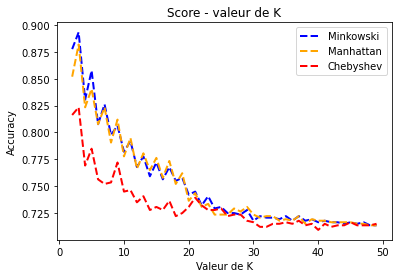

In [23]:
score_minko = []
score_man = []
score_cheb = []
score_euc = []

for k in k_:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    score_minko.append(knn.score(X_test, y_test))

for k in k_:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train, y_train)
    score_man.append(knn.score(X_test, y_test))
    
for k in k_:
    knn = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train, y_train)
    score_cheb.append(knn.score(X_test, y_test))

print('Best_k_minkowski :', score_minko.index(max(score_minko)))
print(f'Best_score_minkowski rate : {max(score_minko):.2%}')
print('Best_k_manhattan :', score_man.index(max(score_man)))
print(f'Best_score_manhattan rate : {max(score_man):.2%}')
print('Best_k_chebyshev :', score_cheb.index(max(score_cheb)))
print(f'Best_score_chebyshev rate : {max(score_cheb):.2%}')

plt.plot(k_, score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(k_, score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(k_, score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend();


In [ ]:
model = KNeighborsClassifier()
k = np.arange(2,50)

train_score, val_score = validation_curve(model, X_train, y_train, 
                                          param_name = 'n_neighbors', 
                                          param_range=k, 
                                          cv=5, 
                                          n_jobs=-1, 
                                          scoring='accuracy')

print('Best_k :', val_score.mean(axis=1).argmax())
print(f'Best_score rate : {np.amax(val_score.mean(axis=1)):.2%}')
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend();

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(knn, X_train, y_train, 
                                                       train_sizes = np.linspace(0.1, 1.0, 10), cv=5, n_jobs=4)

print(train_sizes)
plt.plot(train_sizes, val_scores.mean(axis=1), label='validation')
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('Training examples')
plt.legend();

### SVC

Accuracy for our testing dataset with tuning is : 96.15%
score : 96.15%

err_train : 0.000, err_test : 0.038
Durée : 0:01:20.799125s
MAE : 0.038
RMSE : 0.195
mse train : 0.000
mse test : 0.038
err_train : 0.000, err_test : 0.038


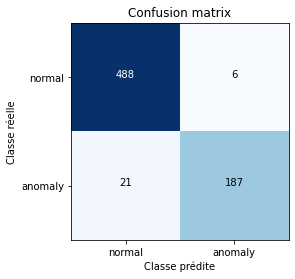

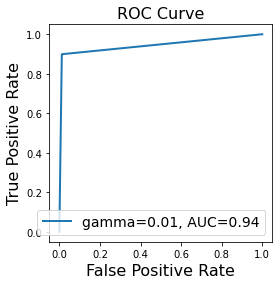

In [24]:
model_8 = SVC(kernel='poly', gamma=0.01)
evaluation(model_8, X, y)

In [25]:
svc = SVC()

svc.fit(X_train, y_train)

y_train_predict = svc.predict(X_train)

y_test_predict = svc.predict(X_test)

err_train = np.mean(y_train != y_train_predict)

err_test = np.mean(y_test != y_test_predict)

print(err_train, err_test)
print(f'score : {svc.score(X_test, y_test):.2%}') 


0.035268970431065194 0.0811965811965812
score : 91.88%


In [ ]:
# Radial Core
C_array = np.logspace(-3, 3, num = 7)
gamma_array = np.logspace(-5, 2, num = 8)

parameters_SVC = {'gamma':gamma_array, 'C':C_array}

svc = SVC(kernel='rbf')

grid = GridSearchCV(svc, parameters_SVC)

grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_

best_C = grid.best_estimator_.C

best_gamma = grid.best_estimator_.gamma

best_parameters_SVC = grid.best_params_

print('CV error =', best_cv_err)
print('best C =', best_C)
print('best gamma =', best_gamma)
print('SVC best parameters = ', best_parameters_SVC)

# Lets's see what the error in the best sample is for the found values of the algorithm parameters :
svc = SVC(kernel = 'rbf', C = best_C, gamma = best_gamma)

svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))

err_test = np.mean(y_test != svc.predict(X_test))

print(err_train, err_test)
print(f'score : {svc.score(X_test, y_test):.2%}') 


In [ ]:
#Line Core
C_array = np.logspace(-3, 3, num = 7)
gamma_array = np.logspace(-5, 2, num = 8)

parameters_SVC = {'gamma':gamma_array, 'C':C_array}

svc = SVC(kernel='linear')

grid = GridSearchCV(svc, parameters_SVC)

grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_

best_C = grid.best_estimator_.C

best_gamma = grid.best_estimator_.gamma

best_parameters_SVC = grid.best_params_

print('CV error =', best_cv_err)
print('best C =', best_C)
print('best gamma =', best_gamma)
print('SVC best parameters = ', best_parameters_SVC)

# Lets's see what the error in the best sample is for the found values of the algorithm parameters :
svc = SVC(kernel = 'linear', C = best_C, gamma = best_gamma)

svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))

err_test = np.mean(y_test != svc.predict(X_test))

print(err_train, err_test)
print(f'score : {svc.score(X_test, y_test):.2%}') 


In [ ]:
#Polynomial Core
C_array = np.logspace(-5, 2, num = 8)
gamma_array = np.logspace(-5, 2, num = 8)
degree_array = [2, 3, 4]

parameters_SVC = {'gamma':gamma_array, 'C':C_array, 'degree':degree_array}

svc = SVC(kernel='poly')

grid = GridSearchCV(svc, parameters_SVC)

grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_

best_C = grid.best_estimator_.C

best_gamma = grid.best_estimator_.gamma

best_degree = grid.best_estimator_.degree

best_parameters_SVC = grid.best_params_

print('CV error =', best_cv_err)
print('best C =', best_C)
print('best gamma =', best_gamma)
print('best degree =', best_degree)

print('SVC best parameters = ', best_parameters_SVC)

# Lets's see what the error in the best sample is for the found values of the algorithm parameters :
svc = SVC(kernel = 'poly', C = best_C, gamma = best_gamma, degree = best_degree)

svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))

err_test = np.mean(y_test != svc.predict(X_test))

print(err_train, err_test)
print(f'score : {svc.score(X_test, y_test):.2%}') 


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters =  {'C': 10}
CV error : 9.000
Accuracy for our training dataset with tuning is : 91.00%
Accuracy for our testing dataset with tuning is : 87.47%

err_train : 0.001, err_test : 0.125
score : 87.47%
Durée : 0:03:21.376874s


Text(0.5, 0, 'Classe prédite')

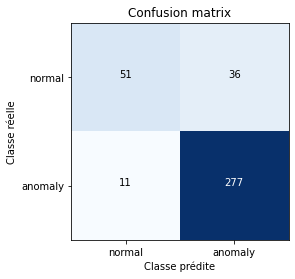

In [73]:
start_time = time.time()
# defining parameter range
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(SVC(kernel='rbf', gamma='scale'), param_grid, scoring='accuracy', n_jobs=-1, refit=True, cv=10, verbose=3)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print how our model looks after hyper-parameter tuning
best_C = grid.best_estimator_.C

best_gamma = grid.best_estimator_.gamma

best_kernel = grid.best_estimator_.kernel

best_degree = grid.best_estimator_.degree

# print best parameter after tuning
best_parameters = grid.best_params_

accuracy = grid.best_score_ *100
best_cv_err = 100 - accuracy

print('Best parameters = ', best_parameters)
print('CV error : {:.3f}'.format(best_cv_err))
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

################################
# Finding Test-Model Accuracy
################################
y_test_pred = grid.predict(X_test)
y_train_pred = grid.predict(X_train)
test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

# Lets's see what the error in the best sample is for the found values of the algorithm parameters :
err_train = np.mean(y_train != y_train_pred)
err_test = np.mean(y_test != y_test_pred)
print(f'\nerr_train : {err_train:.3f}, err_test : {err_test:.3f}') 
print(f'score : {grid.score(X_test, y_test):.2%}') 

end_time = time.time() - start_time
print(f'Durée : {datetime.timedelta(seconds =end_time)}s')

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_true = y_test, y_pred = y_test_pred)
# Create a classification report
class_report = classification_report(y_true = y_test, y_pred = y_test_pred)

# Create heatmap from the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
class_names=['normal', 'anomaly']
plt.title('Confusion matrix')
tick_marks = np.arange(len(class_names)) #[0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')


In [ ]:
C_array = np.logspace(-5, 2, num = 8)
gamma_array = np.logspace(-5, 2, num = 8)
degree_array = [2, 3, 4]

parameters_SVC = {'gamma':gamma_array, 'C':C_array, 'degree':degree_array}

svc = SVC(kernel='poly')

grid = RandomizedSearchCV(svc, parameters_SVC)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(f'score : {grid.score(X_test, y_test):.2%}') 

print(classification_report(y_test, y_pred))

In [ ]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [ ]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

f1_score(y_test, y_pred)
recall_score(y_test, y_pred)

### OPTIMISATION

### Voting classifier

In [ ]:
model_9 = SGDClassifier(random_state=0)
model_10 = DecisionTreeClassifier(random_state=0)
model_11 = KNeighborsClassifier(n_neighbors=2)

model_12 = VotingClassifier([('SGD', model_9),
                           ('Tree', model_10),
                           ('KNN', model_11)],
                          voting='hard')
for model in (model_9, model_10, model_11, model_12):
    model.fit(X_train, y_train)
    print(model.__class__.__name__, model.score(X_test, y_test))

### Bagging

In [ ]:
model_13 = BaggingClassifier(base_estimator=KNeighborsClassifier(),
                         n_estimators=100)
evaluation(model_13, X, y)

### Boosting

In [ ]:
model_14 = AdaBoostClassifier(n_estimators=100, random_state=0)

evaluation(model_14, X, y)

In [ ]:
model_15 = GradientBoostingClassifier(n_estimators=100, random_state=0)

evaluation(model_15, X, y)

### Stacking

In [ ]:
model_16 = StackingClassifier([('SGD', model_9),
                           ('Tree', model_10),
                           ('KNN', model_11)],
                          final_estimator=KNeighborsClassifier())

evaluation(model_16, X, y)

## Save the model

In [ ]:
################################
# méthode 1
from joblib import dump, load
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)

# load the model from disk
loaded_model = joblib.load(filename)
################################
# methode 2
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
  
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))



#Sauvegarder les deux modèles
dump([reg1, reg2], 'regression_model_saved.joblib', compress=1)

reg1_loaded, reg2_loaded = load('regression_model_saved.joblib')